In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType, FloatType


In [2]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("ResearchRnnModel") \
    .getOrCreate()


In [3]:
# Load the dataset using PySpark
df = spark.read.csv('retail_data.csv', header=True, inferSchema=True)

# Show the first few rows
df.show(5)


+--------------+-----------+-------------------+-------------------+----------+--------------------+----------+---------------+-------+---------+---+------+------+----------------+----------+----+---------+-------------------+---------------+-----------+------------+----------------+-------------+------------+---------+---------------+--------------+------------+-------+-----------------+
|Transaction_ID|Customer_ID|               Name|              Email|     Phone|             Address|      City|          State|Zipcode|  Country|Age|Gender|Income|Customer_Segment|      Date|Year|    Month|               Time|Total_Purchases|     Amount|Total_Amount|Product_Category|Product_Brand|Product_Type| Feedback|Shipping_Method|Payment_Method|Order_Status|Ratings|         products|
+--------------+-----------+-------------------+-------------------+----------+--------------------+----------+---------------+-------+---------+---+------+------+----------------+----------+----+---------+----------

In [4]:
# Drop columns that won't be used for the model
df = df.drop('Zipcode', 'Email', 'Phone', 'Name', 'Address','Transaction_ID', 'Customer_ID')


In [5]:
from pyspark.sql.functions import col, sum

# Check for missing values (nulls) in each column
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()



+----+-----+-------+---+------+------+----------------+----+----+-----+----+---------------+------+------------+----------------+-------------+------------+--------+---------------+--------------+------------+-------+--------+
|City|State|Country|Age|Gender|Income|Customer_Segment|Date|Year|Month|Time|Total_Purchases|Amount|Total_Amount|Product_Category|Product_Brand|Product_Type|Feedback|Shipping_Method|Payment_Method|Order_Status|Ratings|products|
+----+-----+-------+---+------+------+----------------+----+----+-----+----+---------------+------+------------+----------------+-------------+------------+--------+---------------+--------------+------------+-------+--------+
| 248|  281|    271|173|   317|   290|             215| 359| 350|  273| 350|            361|   357|         350|             283|          281|           0|     184|            337|           297|         235|    184|       0|
+----+-----+-------+---+------+------+----------------+----+----+-----+----+---------------+

In [6]:
# Drop rows with any missing values in the DataFrame
df = df.dropna()

# Verify that there are no more missing values
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+----+-----+-------+---+------+------+----------------+----+----+-----+----+---------------+------+------------+----------------+-------------+------------+--------+---------------+--------------+------------+-------+--------+
|City|State|Country|Age|Gender|Income|Customer_Segment|Date|Year|Month|Time|Total_Purchases|Amount|Total_Amount|Product_Category|Product_Brand|Product_Type|Feedback|Shipping_Method|Payment_Method|Order_Status|Ratings|products|
+----+-----+-------+---+------+------+----------------+----+----+-----+----+---------------+------+------------+----------------+-------------+------------+--------+---------------+--------------+------------+-------+--------+
|   0|    0|      0|  0|     0|     0|               0|   0|   0|    0|   0|              0|     0|           0|               0|            0|           0|       0|              0|             0|           0|      0|       0|
+----+-----+-------+---+------+------+----------------+----+----+-----+----+---------------+

In [7]:
from pyspark.sql.functions import hour, dayofmonth, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Ensure 'Time' is properly cast and extract 'Hour' and 'Day'
df = df.withColumn("Time", col("Time").cast("timestamp"))
df = df.withColumn("Hour", hour("Time")).withColumn("Day", dayofmonth("Time"))
df = df.drop("Time")  # Drop 'Time' since it's no longer needed

In [8]:
# Define StringIndexers for categorical columns
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid='keep')
    for col in ['City', 'State', 'Country', 'Gender', 'Customer_Segment', 
                'Feedback', 'Shipping_Method', 'Payment_Method', 'Order_Status']
]

In [9]:
# Define OneHotEncoders for indexed columns
encoders = [
    OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded")
    for col in ['City', 'State', 'Country', 'Gender', 'Customer_Segment', 
                'Feedback', 'Shipping_Method', 'Payment_Method', 'Order_Status']
]

In [10]:
# Create a pipeline to apply transformations
pipeline = Pipeline(stages=indexers + encoders)

# Fit the pipeline and transform the data
df_encoded = pipeline.fit(df).transform(df)

In [11]:
# List of numerical features to include
numerical_features = ['Age', 'Income', 'Year', 'Month', 'Total_Purchases', 
                      'Amount', 'Total_Amount', 'Ratings', 'Hour', 'Day']

In [12]:
# List of encoded categorical features
encoded_features = [f"{col}_encoded" for col in [
    'City', 'State', 'Country', 'Gender', 'Customer_Segment', 
    'Feedback', 'Shipping_Method', 'Payment_Method', 'Order_Status'
]]

In [13]:
# Combine all features into the final DataFrame
df_final = df_encoded.select(encoded_features + numerical_features)

# Show the first 5 rows to verify
df_final.show(5)

+----------------+--------------+---------------+--------------+------------------------+----------------+-----------------------+----------------------+--------------------+---+------+----+---------+---------------+-----------+------------+-------+----+---+
|    City_encoded| State_encoded|Country_encoded|Gender_encoded|Customer_Segment_encoded|Feedback_encoded|Shipping_Method_encoded|Payment_Method_encoded|Order_Status_encoded|Age|Income|Year|    Month|Total_Purchases|     Amount|Total_Amount|Ratings|Hour|Day|
+----------------+--------------+---------------+--------------+------------------------+----------------+-----------------------+----------------------+--------------------+---+------+----+---------+---------------+-----------+------------+-------+----+---+
|(130,[68],[1.0])|(54,[1],[1.0])|  (5,[2],[1.0])| (2,[0],[1.0])|           (3,[0],[1.0])|   (4,[0],[1.0])|          (3,[0],[1.0])|         (4,[1],[1.0])|       (4,[1],[1.0])| 21|   Low|2023|September|              3|108.028

In [14]:
from pyspark.sql.functions import col, when

# Define a mapping function for month names to numbers
month_mapping = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}

# Create a new column 'Month_num' by mapping month names to their corresponding numbers
df_final = df_final.withColumn(
    "Month",
    when(col("Month").isin(list(month_mapping.keys())), col("Month"))
    .otherwise(None)
)

# Replace month names using the mapping and cast to integer
for month_name, month_num in month_mapping.items():
    df_final = df_final.withColumn(
        "Month",
        when(col("Month") == month_name, month_num).otherwise(col("Month"))
    )

# Cast the final 'Month' column to integer type
df_final = df_final.withColumn("Month", col("Month").cast("int"))

# Verify the schema to ensure the conversion worked
df_final.printSchema()



root
 |-- City_encoded: vector (nullable = true)
 |-- State_encoded: vector (nullable = true)
 |-- Country_encoded: vector (nullable = true)
 |-- Gender_encoded: vector (nullable = true)
 |-- Customer_Segment_encoded: vector (nullable = true)
 |-- Feedback_encoded: vector (nullable = true)
 |-- Shipping_Method_encoded: vector (nullable = true)
 |-- Payment_Method_encoded: vector (nullable = true)
 |-- Order_Status_encoded: vector (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Income: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Total_Purchases: integer (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Total_Amount: double (nullable = true)
 |-- Ratings: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day: integer (nullable = true)



In [15]:
# Verify the column names and their data types
df_final.printSchema()

# Print the columns available to ensure no typos
print(df_final.columns)



root
 |-- City_encoded: vector (nullable = true)
 |-- State_encoded: vector (nullable = true)
 |-- Country_encoded: vector (nullable = true)
 |-- Gender_encoded: vector (nullable = true)
 |-- Customer_Segment_encoded: vector (nullable = true)
 |-- Feedback_encoded: vector (nullable = true)
 |-- Shipping_Method_encoded: vector (nullable = true)
 |-- Payment_Method_encoded: vector (nullable = true)
 |-- Order_Status_encoded: vector (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Income: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Total_Purchases: integer (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Total_Amount: double (nullable = true)
 |-- Ratings: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day: integer (nullable = true)

['City_encoded', 'State_encoded', 'Country_encoded', 'Gender_encoded', 'Customer_Segment_encoded', 'Feedback_encoded', 'Shipping_Method_encoded', 'Payment_

In [16]:
from pyspark.ml.feature import StringIndexer

# Use StringIndexer to encode Income categories to numeric values
income_indexer = StringIndexer(inputCol="Income", outputCol="Income_index", handleInvalid='keep')

# Apply the transformation
df_final = income_indexer.fit(df_final).transform(df_final)

# Drop the old Income column and rename the new one
df_final = df_final.drop("Income").withColumnRenamed("Income_index", "Income")

# Verify the schema
df_final.printSchema()



root
 |-- City_encoded: vector (nullable = true)
 |-- State_encoded: vector (nullable = true)
 |-- Country_encoded: vector (nullable = true)
 |-- Gender_encoded: vector (nullable = true)
 |-- Customer_Segment_encoded: vector (nullable = true)
 |-- Feedback_encoded: vector (nullable = true)
 |-- Shipping_Method_encoded: vector (nullable = true)
 |-- Payment_Method_encoded: vector (nullable = true)
 |-- Order_Status_encoded: vector (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Total_Purchases: integer (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Total_Amount: double (nullable = true)
 |-- Ratings: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Income: double (nullable = false)



In [17]:
from pyspark.ml.feature import VectorAssembler

# Assemble features into a single vector column
assembler = VectorAssembler(
    inputCols=[col_name for col_name in numerical_features + encoded_features],
    outputCol="features"
)

# Transform the DataFrame
df_final_vector = assembler.transform(df_final)

# Select only 'features' and 'Ratings'
data = df_final_vector.select("features", col("Ratings").cast("float"))

# Split the data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Verify the train set
train_data.show(5)


+--------------------+-------+
|            features|Ratings|
+--------------------+-------+
|(219,[0,1,2,3,4,5...|    4.0|
|(219,[0,1,2,3,4,5...|    5.0|
|(219,[0,1,2,3,4,5...|    4.0|
|(219,[0,1,2,3,4,5...|    5.0|
|(219,[0,1,2,3,4,5...|    5.0|
+--------------------+-------+
only showing top 5 rows



In [18]:
import numpy as np

# Convert PySpark DataFrames to Pandas for easier conversion
train_data_pd = train_data.toPandas()
test_data_pd = test_data.toPandas()

In [19]:
# Extract features and labels from the Pandas DataFrames
X_train = np.array([x.toArray() for x in train_data_pd["features"]])
y_train = train_data_pd["Ratings"].values

X_test = np.array([x.toArray() for x in test_data_pd["features"]])
y_test = test_data_pd["Ratings"].values

In [20]:
# Reshape features for RNN input (samples, timesteps, features)
# Assuming 1 timestep since it's tabular data
X_train = np.expand_dims(X_train, axis=1)  # (samples, 1, features)
X_test = np.expand_dims(X_test, axis=1)    # (samples, 1, features)

# Check shapes to confirm
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (237373, 1, 219), y_train shape: (237373,)
X_test shape: (58873, 1, 219), y_test shape: (58873,)


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Set random seed for reproducibility
tf.random.set_seed(42)

# Define the RNN model architecture
model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(32, activation='relu'),  # Hidden dense layer
    Dense(1)  # Output layer for regression (predicting ratings)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display the model's architecture
model.summary()



C:\Users\alexl\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64)


Epoch 1/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 205.1897 - mae: 5.9433 - val_loss: 1.6162 - val_mae: 1.1163
Epoch 2/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.4980 - mae: 0.9511 - val_loss: 0.3981 - val_mae: 0.5253
Epoch 3/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.6186 - mae: 0.5741 - val_loss: 0.0726 - val_mae: 0.2253
Epoch 4/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.2399 - mae: 0.3463 - val_loss: 0.0713 - val_mae: 0.2337
Epoch 5/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0734 - mae: 0.1905 - val_loss: 0.2759 - val_mae: 0.4116
Epoch 6/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0621 - mae: 0.1606 - val_loss: 0.2943 - val_mae: 0.4377
Epoch 7/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.1398 - mae: 0.1488 - val_loss: 0.2296 - val_mae: 0.4175
Epoch 8/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.2144 - mae: 0.1787 - val_loss: 0.2754 - val_mae: 0.4605
Epoch 9/20
3709/3709 ━━━━━━━━━

In [23]:
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")


1840/1840 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2633 - mae: 0.4486
Test Loss (MSE): 0.27554139494895935
Test MAE: 0.46109792590141296


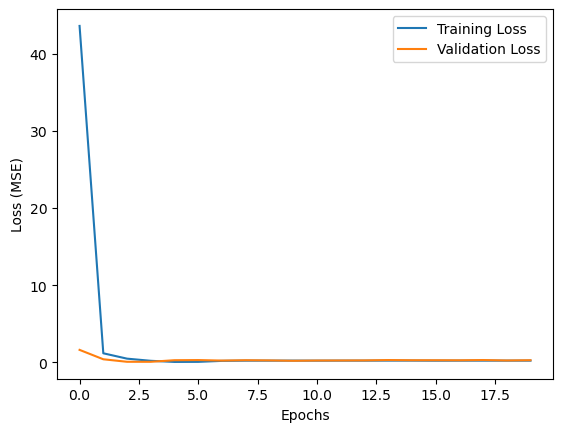

In [24]:
# Plot training history
import matplotlib.pyplot as plt

# Plot loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Re-train the model with EarlyStopping
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    validation_data=(X_test, y_test), 
    batch_size=64, 
    callbacks=[early_stopping]
)



Epoch 1/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.2230 - mae: 0.1628 - val_loss: 0.2687 - val_mae: 0.4596
Epoch 2/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.2186 - mae: 0.1602 - val_loss: 0.2651 - val_mae: 0.4510
Epoch 3/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.2213 - mae: 0.1604 - val_loss: 0.2820 - val_mae: 0.4672
Epoch 4/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.2168 - mae: 0.1549 - val_loss: 0.2666 - val_mae: 0.4555
Epoch 5/20
3709/3709 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.2208 - mae: 0.1610 - val_loss: 0.2799 - val_mae: 0.4619


In [26]:
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

1840/1840 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2576 - mae: 0.4426
Test Loss (MSE): 0.2650744616985321
Test MAE: 0.4510113298892975


In [27]:
# The MSE is  lower than the previous results (0.3351), indicating an improvement in how well the model predicts customer ratings.
# the MAE shows a better result compared to the earlier 0.5110. This suggests that your model is making more accurate predictions

In [28]:
# Generate predictions on the test set
y_pred = model.predict(X_test)


1840/1840 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [29]:
# Flatten the predictions and test labels to ensure they align
y_pred = y_pred.flatten()
y_test_flat = y_test.flatten()

# Print the first 10 predictions vs actual ratings for comparison
for i in range(10):
    print(f"Actual Rating: {y_test_flat[i]}, Predicted Rating: {y_pred[i]:.2f}")

# Round the predictions for easier comparison with actual ratings
y_pred_rounded = np.round(y_pred)

print("\nFirst 10 Rounded Predictions:")
for i in range(10):
    print(f"Actual: {y_test_flat[i]}, Predicted (Rounded): {y_pred_rounded[i]}")

Actual Rating: 4.0, Predicted Rating: 3.44
Actual Rating: 4.0, Predicted Rating: 3.43
Actual Rating: 4.0, Predicted Rating: 3.43
Actual Rating: 5.0, Predicted Rating: 4.24
Actual Rating: 5.0, Predicted Rating: 4.23
Actual Rating: 5.0, Predicted Rating: 4.23
Actual Rating: 4.0, Predicted Rating: 3.43
Actual Rating: 5.0, Predicted Rating: 4.23
Actual Rating: 5.0, Predicted Rating: 4.24
Actual Rating: 4.0, Predicted Rating: 3.44

First 10 Rounded Predictions:
Actual: 4.0, Predicted (Rounded): 3.0
Actual: 4.0, Predicted (Rounded): 3.0
Actual: 4.0, Predicted (Rounded): 3.0
Actual: 5.0, Predicted (Rounded): 4.0
Actual: 5.0, Predicted (Rounded): 4.0
Actual: 5.0, Predicted (Rounded): 4.0
Actual: 4.0, Predicted (Rounded): 3.0
Actual: 5.0, Predicted (Rounded): 4.0
Actual: 5.0, Predicted (Rounded): 4.0
Actual: 4.0, Predicted (Rounded): 3.0


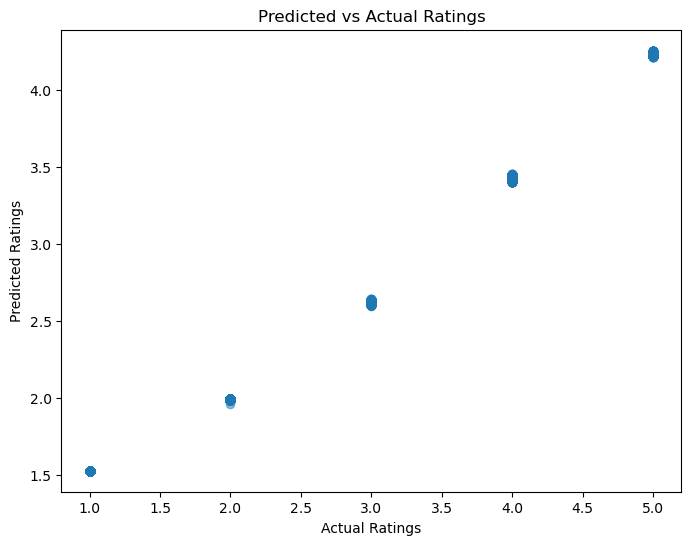

In [30]:
import matplotlib.pyplot as plt

# Scatter plot to visualize how well predictions align with actual ratings
plt.figure(figsize=(8, 6))
plt.scatter(y_test_flat, y_pred, alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()


In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(y_test_flat, y_pred)
mae = mean_absolute_error(y_test_flat, y_pred)
r2 = r2_score(y_test_flat, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Test MSE: 0.2651
Test MAE: 0.4510
R² Score: 0.8472


In [32]:
# The model's predictions are close to the actual values, although there’s a slight underestimation and room for improvement

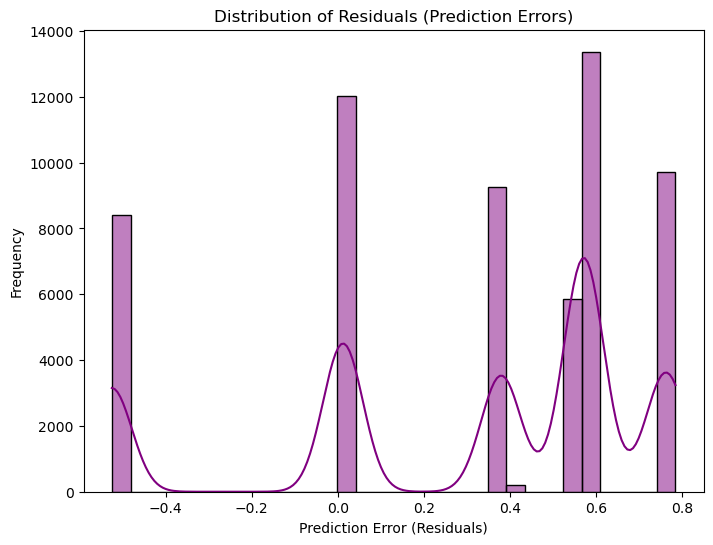

In [33]:
import seaborn as sns

# Calculate residuals (errors)
residuals = y_test - y_pred

# Plot residuals using Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.xlabel('Prediction Error (Residuals)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Prediction Errors)')
plt.show()



In [34]:
# There is quite a bit of deviations from zero may indicate that certain ratings are harder to predict accurately

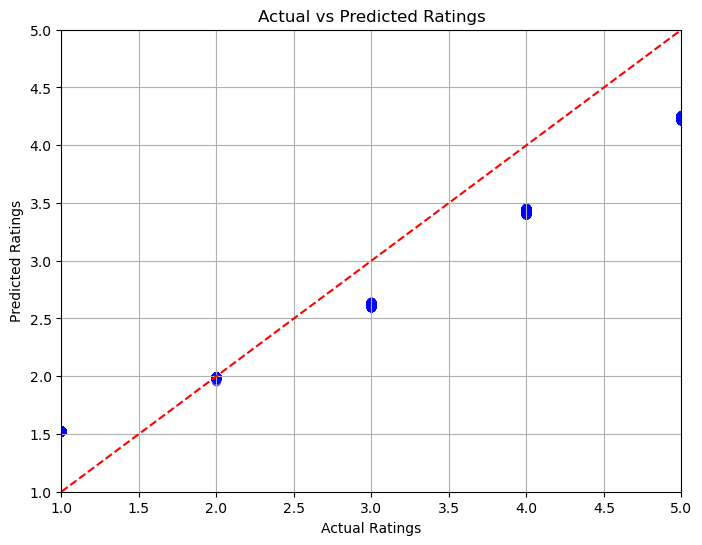

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of actual vs predicted ratings
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')

# Red dashed line representing perfect predictions
plt.plot([1, 5], [1, 5], color='red', linestyle='--')

# Set axis limits from 1 to 5 (same range as ratings)
plt.xlim(1, 5)
plt.ylim(1, 5)

# Adding labels and title
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')

# Display plot
plt.grid(True)
plt.show()


In [36]:
# ok based on the points on the scatter plot i can see that the points are slighly below the red line incicating 
# that there may be slight bias


In [37]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define a learning rate decay function
def lr_schedule(epoch, lr):
    return lr * 0.95  # Reducing the learning rate by 5% every epoch

# Initialize the model
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(BatchNormalization())  # Batch Normalization after LSTM
model.add(Dropout(0.3))  # Dropout to reduce overfitting

model.add(LSTM(64, activation='tanh'))
model.add(BatchNormalization())  # Batch Normalization
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))  # Dense layer with ReLU activation
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

C:\Users\alexl\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_callback = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping, lr_callback]
)

Epoch 1/50
7418/7418 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - loss: 1.9811 - mae: 1.2042 - val_loss: 1.7561 - val_mae: 1.1522 - learning_rate: 9.5000e-04
Epoch 2/50
7418/7418 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - loss: 0.8782 - mae: 0.7187 - val_loss: 0.1877 - val_mae: 0.3488 - learning_rate: 9.0250e-04
Epoch 3/50
7418/7418 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - loss: 0.4193 - mae: 0.4331 - val_loss: 0.2132 - val_mae: 0.3391 - learning_rate: 8.5737e-04
Epoch 4/50
7418/7418 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - loss: 0.3930 - mae: 0.3910 - val_loss: 0.4651 - val_mae: 0.5706 - learning_rate: 8.1451e-04
Epoch 5/50
7418/7418 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - loss: 0.3883 - mae: 0.3828 - val_loss: 0.3799 - val_mae: 0.4974 - learning_rate: 7.7378e-04
Epoch 6/50
7418/7418 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - loss: 0.3903 - mae: 0.3821 - val_loss: 0.3699 - val_mae: 0.4623 - learning_rate: 7.3509e-04
Epoch 7/50
7418/7418 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - loss: 0.3790 - mae: 0.3711 - val_loss: 0.3519 - v

In [39]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

1840/1840 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2015 - mae: 0.3628
Test Loss (MSE): 0.1877
Test MAE: 0.3488


In [40]:
# Generate predictions on the test set
y_pred = model.predict(X_test)



1840/1840 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [41]:
# Flatten the predictions and test labels to ensure they align
y_pred = y_pred.flatten()
y_test_flat = y_test.flatten()

# Print the first 10 predictions vs actual ratings for comparison
for i in range(10):
    print(f"Actual Rating: {y_test_flat[i]}, Predicted Rating: {y_pred[i]:.2f}")

# Round the predictions for easier comparison with actual ratings
y_pred_rounded = np.round(y_pred)

print("\nFirst 10 Rounded Predictions:")
for i in range(10):
    print(f"Actual: {y_test_flat[i]}, Predicted (Rounded): {y_pred_rounded[i]}")

Actual Rating: 4.0, Predicted Rating: 4.14
Actual Rating: 4.0, Predicted Rating: 4.25
Actual Rating: 4.0, Predicted Rating: 4.21
Actual Rating: 5.0, Predicted Rating: 4.37
Actual Rating: 5.0, Predicted Rating: 4.40
Actual Rating: 5.0, Predicted Rating: 4.51
Actual Rating: 4.0, Predicted Rating: 4.15
Actual Rating: 5.0, Predicted Rating: 4.36
Actual Rating: 5.0, Predicted Rating: 4.52
Actual Rating: 4.0, Predicted Rating: 4.11

First 10 Rounded Predictions:
Actual: 4.0, Predicted (Rounded): 4.0
Actual: 4.0, Predicted (Rounded): 4.0
Actual: 4.0, Predicted (Rounded): 4.0
Actual: 5.0, Predicted (Rounded): 4.0
Actual: 5.0, Predicted (Rounded): 4.0
Actual: 5.0, Predicted (Rounded): 5.0
Actual: 4.0, Predicted (Rounded): 4.0
Actual: 5.0, Predicted (Rounded): 4.0
Actual: 5.0, Predicted (Rounded): 5.0
Actual: 4.0, Predicted (Rounded): 4.0


In [42]:
# Chaning the dropout from 0.3 to 0.2 gives more stable and higher predictions, particularly for ratings around 4 and 5.
# This suggests that the model has learned to better predict upper-range values

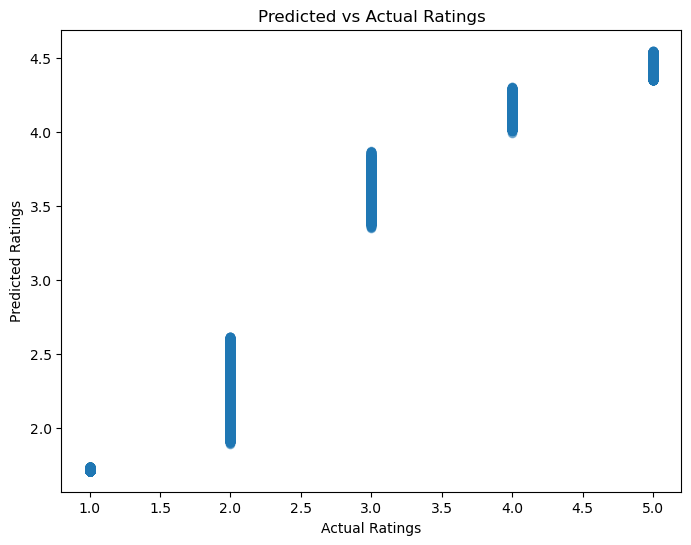

In [43]:
import matplotlib.pyplot as plt

# Scatter plot to visualize how well predictions align with actual ratings
plt.figure(figsize=(8, 6))
plt.scatter(y_test_flat, y_pred, alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(y_test_flat, y_pred)
mae = mean_absolute_error(y_test_flat, y_pred)
r2 = r2_score(y_test_flat, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Test MSE: 0.1877
Test MAE: 0.3488
R² Score: 0.8918


In [45]:
# Lower MSE means the improved model makes smaller squared errors on average
# Lower MAE suggests the model’s predictions are closer to the actual ratings on average
# The higher R² indicates the model explains more variance in the data.

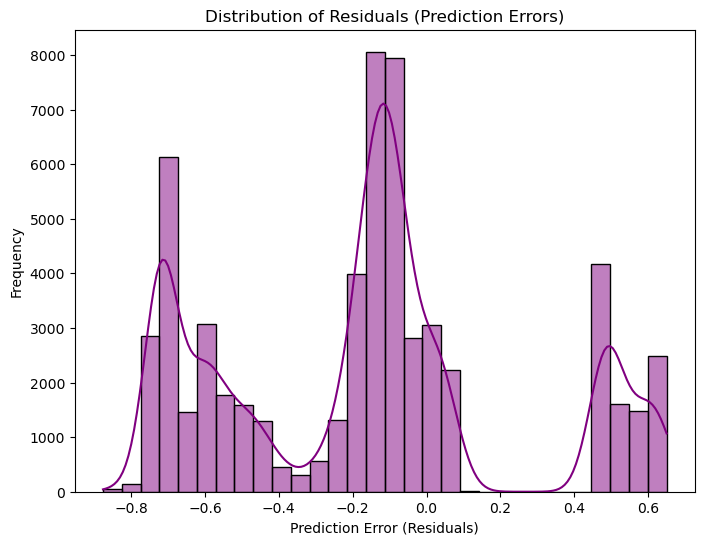

In [46]:
import seaborn as sns

# Calculate residuals (errors)
residuals = y_test - y_pred

# Plot residuals using Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.xlabel('Prediction Error (Residuals)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Prediction Errors)')
plt.show()

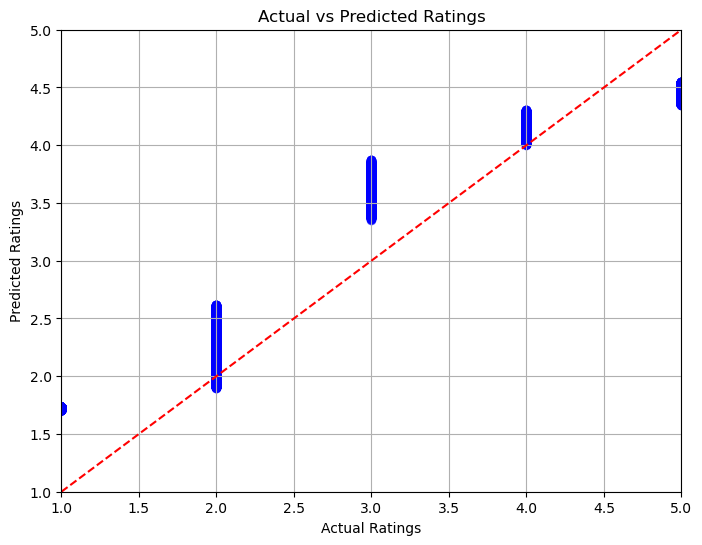

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of actual vs predicted ratings
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')

# Red dashed line representing perfect predictions
plt.plot([1, 5], [1, 5], color='red', linestyle='--')

# Set axis limits from 1 to 5 (same range as ratings)
plt.xlim(1, 5)
plt.ylim(1, 5)

# Adding labels and title
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')

# Display plot
plt.grid(True)
plt.show()

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Round the continuous predictions to the nearest integer for classification purposes
y_pred_rnn_rounded = np.rint(y_pred).astype(int)  # Round and cast to integer
y_test_rounded = np.rint(y_test).astype(int)      # Ensure true labels are integers

# Calculate precision, recall, and F1-score
rnn_precision = precision_score(y_test_rounded, y_pred_rnn_rounded, average='macro', zero_division=1)
rnn_recall = recall_score(y_test_rounded, y_pred_rnn_rounded, average='macro', zero_division=1)
rnn_f1 = f1_score(y_test_rounded, y_pred_rnn_rounded, average='macro', zero_division=1)

# Print the results
print(f"RNN Precision: {rnn_precision:.4f}")
print(f"RNN Recall: {rnn_recall:.4f}")
print(f"RNN F1-Score: {rnn_f1:.4f}")



RNN Precision: 0.8069
RNN Recall: 0.5342
RNN F1-Score: 0.4974


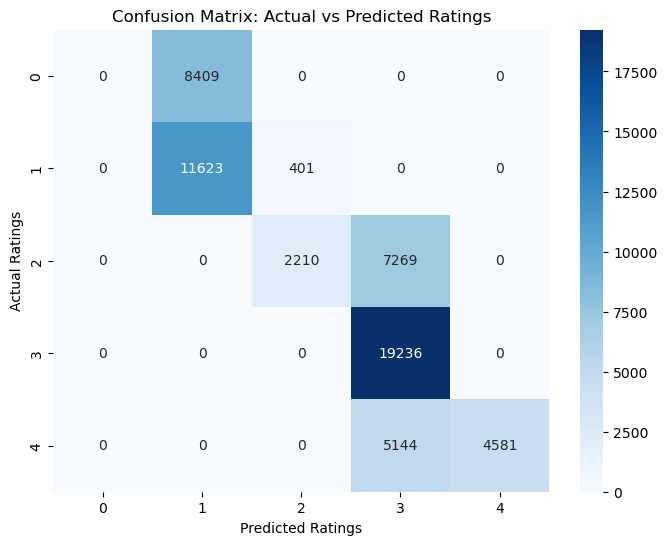

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_rounded, y_pred_rnn_rounded)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.title('Confusion Matrix: Actual vs Predicted Ratings')
plt.show()


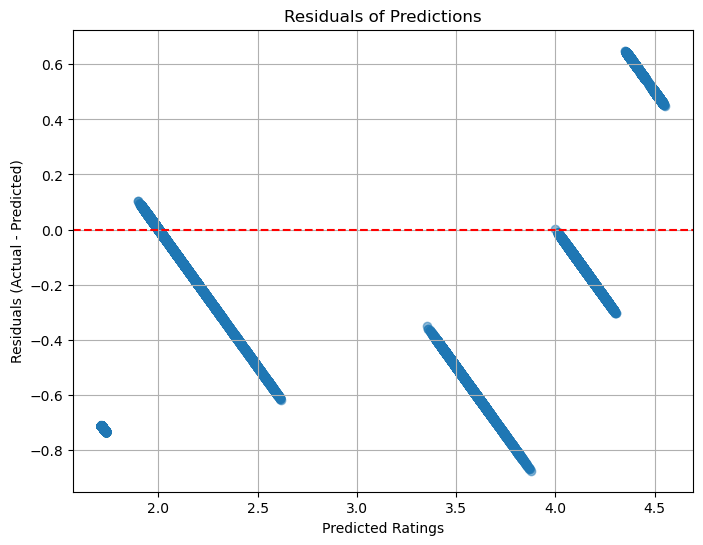

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_pred are already defined
# Calculate residuals
residuals = y_test - y_pred

# Create a figure for the residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='red', linestyle='--')

# Adding titles and labels
plt.title('Residuals of Predictions')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals (Actual - Predicted)')

# Display the plot
plt.grid(True)
plt.show()




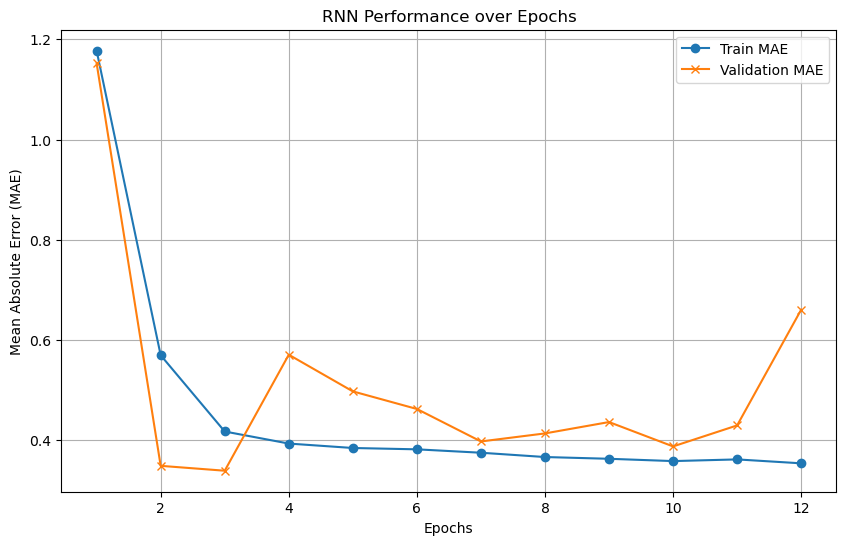

In [51]:
import matplotlib.pyplot as plt

# Extract MAE values from the training history
train_mae = history.history['mae']        # Training MAE
val_mae = history.history['val_mae']      # Validation MAE

# Define the number of epochs
epochs = range(1, len(train_mae) + 1)

# Plot MAE for each epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_mae, label='Train MAE', marker='o')
plt.plot(epochs, val_mae, label='Validation MAE', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('RNN Performance over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# The RNN performance plot from the training MAE demonstrates a significant decrease within the initial epochs, indicating 
# rapid learning and adjustment to the training data.
# After approximately five epochs, the MAE shows the trend of the training MAE which has a steep decrease at the 
# first few epochs, suggesting strong learning and adjustment to the training data
# The validation MAE seems to be stabilizing around lower values after five or so epochs, which indicates that the model 
# is able to learn the underlying patterns in the data without suffering from overfitting